In [3]:
!pip3 install opencv-contrib-python

  Using cached opencv_contrib_python-4.9.0.80-cp37-abi3-macosx_11_0_arm64.whl.metadata (20 kB)
Using cached opencv_contrib_python-4.9.0.80-cp37-abi3-macosx_11_0_arm64.whl (44.2 MB)


In [1]:
import numpy as np
import os
import random
import torch
from torch import nn
import torch.nn.functional as F
import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
from vit import ViT
from train_vit import set_seed, prepare_dataloaders
import cv2



In [2]:
# set the seed
set_seed(1)

# prepare the dataloaders
trainloader, testloader, trainset, testset = prepare_dataloaders(batch_size=1)

0


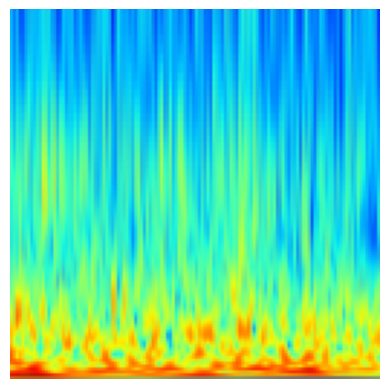

In [17]:
# get the image
# image, label = trainset[9]
image, label = trainset[16]
print(label)

# visualize the image
# img_grid = torchvision.utils.make_grid(image, normalize=True, pad_value=0.9)
img_grid = image.permute(1, 2, 0)
plt.imshow(img_grid)
plt.axis("off")
plt.show()


In [18]:
# load the model
model = torch.load("model.pth").to("cpu")
# transform = transforms.Compose(
    # [transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
# )

In [19]:
image.size()

torch.Size([3, 128, 128])

In [20]:
x = transform(image).unsqueeze(0)
result, att_mat_list = model(image.unsqueeze(0))
print("layer num:", len(att_mat_list))
print("att_mat size:", att_mat_list[0].size())

layer num: 4
att_mat size: torch.Size([4, 65, 65])


In [21]:
att_matrices = torch.stack(att_mat_list)
print(att_matrices.size())
# att_matrices = att_matrices.mean(dim=1)
att_matrices, _ = att_matrices.min(dim=1)
att_matrices

torch.Size([4, 4, 65, 65])


tensor([[[3.5589e-05, 1.0343e-05, 7.3171e-05,  ..., 1.6046e-05,
          4.4561e-06, 8.5708e-06],
         [4.4946e-04, 5.6815e-04, 5.6987e-03,  ..., 5.0192e-04,
          1.4820e-04, 2.0665e-04],
         [1.6318e-03, 2.7657e-03, 7.3289e-03,  ..., 1.5722e-03,
          1.6059e-03, 7.4584e-04],
         ...,
         [1.6429e-04, 8.3487e-04, 1.5872e-03,  ..., 6.5497e-04,
          8.6870e-04, 5.7923e-04],
         [2.2034e-04, 2.0227e-03, 1.4367e-03,  ..., 6.8512e-04,
          6.7497e-04, 1.8530e-04],
         [3.2290e-04, 7.9760e-03, 3.2174e-03,  ..., 8.1663e-04,
          7.9945e-04, 3.4454e-04]],

        [[6.4354e-03, 2.3059e-02, 2.0941e-02,  ..., 1.1753e-03,
          6.8805e-04, 8.4332e-04],
         [8.7391e-03, 9.2170e-03, 1.0391e-02,  ..., 5.8561e-03,
          6.0911e-03, 9.3447e-03],
         [7.8496e-03, 6.9976e-03, 7.5683e-03,  ..., 9.2473e-03,
          4.8369e-03, 1.2202e-02],
         ...,
         [7.1963e-03, 3.3809e-03, 4.4140e-03,  ..., 3.7972e-03,
          5.453

In [22]:
att_matrices = torch.stack(att_mat_list)
print(att_matrices.size())
# att_matrices = att_matrices.mean(dim=1)
# att_matrices, _ = att_matrices.min(dim=1)
att_matrices, _ = att_matrices.max(dim=1)
print(att_matrices.size())
residual_att = torch.eye(att_matrices.size(1))
print(residual_att.size())
aug_att_matrices = att_matrices + residual_att
print(aug_att_matrices.sum(dim=-1).unsqueeze(-1).size())
aug_att_matrices = aug_att_matrices / aug_att_matrices.sum(dim=-1).unsqueeze(-1)


torch.Size([4, 4, 65, 65])
torch.Size([4, 65, 65])
torch.Size([65, 65])
torch.Size([4, 65, 1])


In [23]:
roll_out_atts = torch.zeros(aug_att_matrices.size())
roll_out_atts[0] = aug_att_matrices[0]

for n in range(1, aug_att_matrices.size(0)):
    roll_out_atts[n] = torch.matmul(aug_att_matrices[n], roll_out_atts[n-1])

v = roll_out_atts[-1]
grid_size = int(np.sqrt(aug_att_matrices.size(-1)))
mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
mask = cv2.resize(mask / mask.max(), (128, 128))[..., np.newaxis]
print(v[0, 1:].shape)
print(mask.shape)
print(mask)

torch.Size([64])
(128, 128, 1)
[[[0.28797942]
  [0.28797942]
  [0.28797942]
  ...
  [0.19887236]
  [0.19887236]
  [0.19887236]]

 [[0.28797942]
  [0.28797942]
  [0.28797942]
  ...
  [0.19887236]
  [0.19887236]
  [0.19887236]]

 [[0.28797942]
  [0.28797942]
  [0.28797942]
  ...
  [0.19887236]
  [0.19887236]
  [0.19887236]]

 ...

 [[0.26286647]
  [0.26286647]
  [0.26286647]
  ...
  [0.25579357]
  [0.25579357]
  [0.25579357]]

 [[0.26286647]
  [0.26286647]
  [0.26286647]
  ...
  [0.25579357]
  [0.25579357]
  [0.25579357]]

 [[0.26286647]
  [0.26286647]
  [0.26286647]
  ...
  [0.25579357]
  [0.25579357]
  [0.25579357]]]


In [24]:
max_result = (image.permute(1, 2, 0).numpy()*255.0*mask).astype(np.uint8)

In [25]:
# result = (mask * image.permute(1, 2, 0).numpy() + (1 - mask) * 255).astype(np.uint8)
min_result = (image.permute(1, 2, 0).numpy()*255.0*mask).astype(np.uint8)

# print(result)

In [26]:
# print(image.permute(1, 2, 0).numpy()*255.0)
mean_result = (image.permute(1, 2, 0).numpy()*255.0*mask).astype(np.uint8)

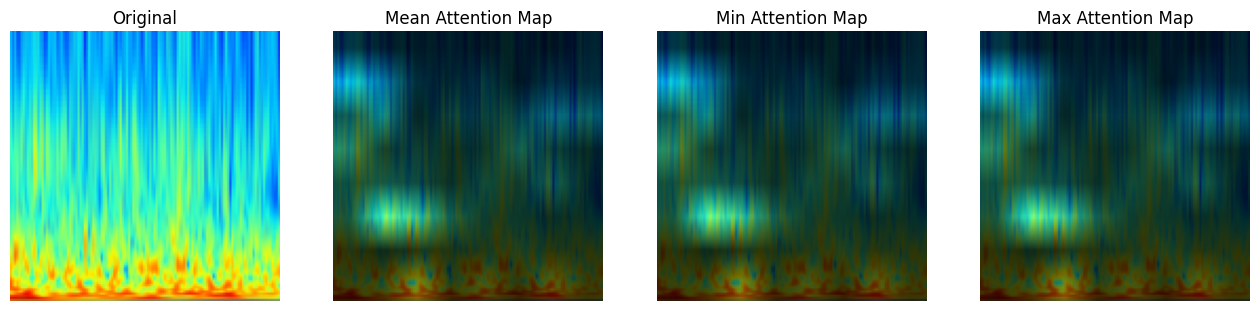

In [27]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(16, 16))

ax1.set_title('Original')
ax2.set_title('Mean Attention Map')
ax3.set_title('Min Attention Map')
ax4.set_title('Max Attention Map')
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax4.axis('off')
_ = ax1.imshow(image.permute(1, 2, 0))
_ = ax2.imshow(mean_result)
_ = ax3.imshow(min_result)
_ = ax4.imshow(max_result)

In [1]:
plt.imshow(image.permute(1, 2, 0))
plt.axis('off')

NameError: name 'plt' is not defined